In [71]:
import networkx as nx
# Built-in libraries
import os
import sys
import glob
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
from tqdm import tqdm
from datetime import datetime, timedelta
from PIL import Image, ImageDraw, ImageFont

# Makerspace libraries
if os.path.isfile('./makerspace.py'): from makerspace import *
#
# else: from helpers.makerspace import *


##############
# timestamps #
##############

def return_unix_time(curr_time, scale=1000):
    ''' converts a string value into a unix timestamp (millisecond) 
        this code works for the following formats:
            - 2022-03-05 12:42:40.133000-05:00
            - 2022-03-23T14:59:56.533Z '''
    if 'T' in curr_time: curr_time = curr_time.replace('T', ' ')
    if 'Z' in curr_time: curr_time = curr_time.replace('Z', '')
    if '-05:00' in curr_time: curr_time = curr_time.replace('-05:00', '') 
    try:    
        curr_time = datetime.strptime(curr_time, "%Y-%m-%d %H:%M:%S.%f")
        return int(curr_time.timestamp() * scale)
    except Exception as e:
        curr_time = datetime.strptime(curr_time, "%Y-%m-%d %H:%M:%S")
        return int(curr_time.timestamp() * scale)

def add_unix_time_to_df(df, scale='millisecond'): 
    ''' add a column  that represents the unix time of a dataframe '''
    multiplier = 1
    if scale == 'millisecond': multiplier = 1000
    df['unix'] = df.apply(lambda x: return_unix_time(x['timestamp'],scale=multiplier), axis=1)

def which_hour(curr_time):
    ''' converts a string value into a unix timestamp (millisecond) 
        this code works for the following formats:
            - 2022-03-05 12:42:40.133000-05:00
            - 2022-03-23T14:59:56.533Z '''
    if 'T' in curr_time: curr_time = curr_time.replace('T', ' ')
    if 'Z' in curr_time: curr_time = curr_time.replace('Z', '')
    if '-05:00' in curr_time: curr_time = curr_time.replace('-05:00', '') 
    try:    
        curr_time = datetime.strptime(curr_time, "%Y-%m-%d %H:%M:%S.%f")
        return curr_time.hour
    except Exception as e:
        curr_time = datetime.strptime(curr_time, "%Y-%m-%d %H:%M:%S")
        return curr_time.hour

def add_hour_to_df(df):
    df['hour'] = df.apply(lambda x: which_hour(x['timestamp']), axis=1)

def convert_datetime(time_str):
  time_zone = time_str.split('-')[-1]
  time_zone = time_zone.split(':')[0] + time_zone.split(':')[1]
  time_date = time_str.split(' ')[0]
  time_time = time_str.split(' ')[1].split('-')[0]
  reformat_time = '{} {} -{}'.format(time_date,time_time,time_zone)

  try:
    return datetime.strptime(reformat_time, '%Y-%m-%d %H:%M:%S.%f %z')
  except:
    return datetime.strptime(reformat_time, '%Y-%m-%d %H:%M:%S %z')

def obtain_target_times(in_df_student,in_every_sec_freq):
  
  # obtain starting df_freq
  df_freq = in_df_student.copy()
  df_freq.sort_values(by=['timestamp'],inplace=True)
  df_freq.reset_index(inplace=True,drop=True)

  # obtain start_time, end_time and first target_time
  start_time = df_freq.at[0,'timestamp']
  end_time = df_freq.at[len(df_freq)-1,'timestamp']
  target_time = start_time + timedelta(seconds=in_every_sec_freq)

  # obtain target_times
  target_times = [start_time]

  def determine_time_diff(input_time):
    return (input_time - target_time).total_seconds()

  while target_time < end_time:
    df_freq['time_diff'] = df_freq['timestamp'].apply(determine_time_diff)
    df_freq = df_freq[df_freq['time_diff']>=0]
    potential_time = df_freq.at[df_freq['time_diff'].idxmin(),'timestamp']
    if (potential_time - target_time).total_seconds() < in_every_sec_freq:
      target_times.append(potential_time)
    
    target_time = target_time + timedelta(seconds=in_every_sec_freq)

  return target_times

############
# calendar #
############

def add_events(df, cohort): 
    ''' indicate when we had office hours or lab sections '''
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
    df['office'] = df['datetime'].apply(lambda x: cohort.is_office(x))
    df['section'] = df['datetime'].apply(lambda x: cohort.is_section(x))


########################
# Self-touch behaviors #
########################

def add_self_touch(df, threshold=0.1):
    ''' creates a new column called "self_touch" that indicates if the person
        touched his/her face with his/her hand (1) or not (0) for each row '''
    
    df['self_touch'] = df.apply(lambda x: min(
         dist_two_points_3d((x['nose_x'],x['nose_y'],x['nose_z']), 
                            (x['left_wrist_x'],x['left_wrist_y'],x['left_wrist_z'])), 
         dist_two_points_3d((x['nose_x'],x['nose_y'],x['nose_z']), 
                            (x['right_wrist_x'],x['right_wrist_y'],x['right_wrist_z']))), 
    axis=1)
    
    df['self_touch'] = df['self_touch'].apply(lambda x: 1 if x <= threshold else '')


############
# Movement #
############

def add_movement(df, threshold=5, verbose=False):
    
    # assumes that most people won't be moving
    df['is_moving'] = ''
    
    # keep track of the last position for each person
    positions = {}

    # go through the data using numpy arrays
    persons = df['person_identity'].to_numpy()
    nosex = df['nose_x'].to_numpy()
    nosey = df['nose_y'].to_numpy()
    time = df['datetime']

    # go through the data
    #for i in range(0,df.shape[0]-1):
    for i,v in time.items():

        # get the current time
        curr_time = time[i]
        if type(curr_time) == str: 
            curr_time = datetime.strptime(time[i], "%Y-%m-%d %H:%M:%S")
        person = persons[i]
        if np.isnan([nosex[i],nosey[i]]).any(): continue
        nose = transform_coordinates(nosex[i],nosey[i])

        # check if this person exists
        if person in positions.keys():
            prev_nose = positions[person][1]
            prev_time = positions[person][0]
            if abs(curr_time - prev_time).total_seconds() <= 1:
                dist = dist_two_points(nose,prev_nose)
                df.at[i,'move_dist'] = dist
                if dist < threshold: df.at[i,'is_moving'] = 1

        # update the last seen position
        positions[person] = (curr_time,nose)

        # print progress
        if i % 10000 == 0 and verbose:
            sys.stdout.write("\r")
            sys.stdout.write(str(i) + "/"+str(df.shape[0]))
            sys.stdout.flush()

        
def add_joint_movement(df, joint):
    
    # assumes that most people won't be moving
    df[joint+'_movement'] = ''
    
    # keep track of the last position for each person
    positions = {}

    # go through the data using numpy arrays
    persons = df['person_identity'].to_numpy()
    joint_x = df[joint+'_x'].to_numpy()
    joint_y = df[joint+'_y'].to_numpy()
    joint_z = df[joint+'_z'].to_numpy()
    time = df['datetime']

    # go through the data
    for i,v in time.items():

        # get the current time
        curr_time = time[i]
        if type(curr_time) == str: 
            curr_time = datetime.strptime(time[i], "%Y-%m-%d %H:%M:%S")
        person = persons[i]
        if np.isnan([joint_x[i],joint_y[i]]).any(): continue
        jointxyz = joint_x[i],joint_y[i],joint_z[i]

        # check if this person exists
        if person in positions.keys():
            prev_joint = positions[person][1]
            prev_time = positions[person][0]
            if abs(curr_time - prev_time).total_seconds() <= 1:
                dist = dist_two_points_3d(jointxyz,prev_joint) * 90
                df.at[i,joint+'_movement'] = dist

        # update the last seen position
        positions[person] = (curr_time,jointxyz)
       


            
def add_two_joints_movement(df, joint1, joint2):
    
    # find joint name
    joint_name = joint1.replace('right_','').replace('left_','')
    df[joint_name+'_movement'] = ''
    
    # keep track of the last position for each person
    positions = {}

    # go through the data using numpy arrays
    persons = df['person_identity'].to_numpy()
    lx,ly,lz = df[joint1+'_x'].to_numpy(),df[joint1+'_y'].to_numpy(),df[joint1+'_z'].to_numpy()
    rx,ry,rz = df[joint2+'_x'].to_numpy(),df[joint2+'_y'].to_numpy(),df[joint2+'_z'].to_numpy()
    time = df['datetime']

    # go through the data
    for i,v in time.items():

        # get the current time
        curr_time = time[i]
        if type(curr_time) == str: 
            curr_time = datetime.strptime(time[i], "%Y-%m-%d %H:%M:%S")
        person = persons[i]
        if np.isnan([lx[i],ly[i],lz[i],rx[i],ry[i],rz[i]]).any(): continue
        l = lx[i],ly[i],lz[i]
        r = rx[i],ry[i],rz[i]

        # check if this person exists
        if person in positions.keys():
            prev_l,prev_r = positions[person][1],positions[person][2]
            prev_time = positions[person][0]
            if abs(curr_time - prev_time).total_seconds() <= 1:
                dist = dist_two_points_3d(l,prev_l)+dist_two_points(r,prev_r)
                df.at[i,joint_name+'_movement'] = dist * 90

        # update the last seen position
        positions[person] = (curr_time,l,r)
    
        
########################
# social Interactions  #
########################

def add_social_interactions(df, threshold=100, verbose=False):
    ''' add two columns: 'is_with', which indicates someone that the person is close to;
        and 'is_oriented_toward', which indicates someone who is close and where 
        their lines of sight (orthogonal from shoulders to nose) intersect'''

    # go through the data using numpy arrays
    persons = df['person_identity'].to_numpy()
    lshoulderx = df['left_shoulder_x'].to_numpy()
    lshouldery = df['left_shoulder_y'].to_numpy()
    rshoulderx = df['right_shoulder_x'].to_numpy()
    rshouldery = df['right_shoulder_y'].to_numpy()
    nosex = df['nose_x'].to_numpy()
    nosey = df['nose_y'].to_numpy()
    time = df['datetime'].to_numpy()

    # go through the data
    for i in range(0,df.shape[0]-1):

        # get the data
        t = time[i]
        if np.isnan([nosex[i],nosey[i]]).any(): continue
        hx = (lshoulderx[i]+rshoulderx[i])/2.0
        hy = (lshouldery[i]+rshouldery[i])/2.0
        head = transform_coordinates(hx,hy)
        nose = transform_coordinates(nosex[i],nosey[i])

        # check the next entries
        j = i+1
        while(time[j] == time[i] and j < df.shape[0]-1):

            # check if we have data
            if not np.isnan([nosex[j],nosey[j]]).any(): 
                nosej = transform_coordinates(nosex[j],nosey[j])
                
                # close proximity
                if dist_two_points(nose,nosej) < threshold: 
                    
                    # create a column to keep track of the other person
                    df.at[i,'is_with'] = persons[j]

                    # check body orientation
                    hxj = (lshoulderx[j]+rshoulderx[j])/2.0
                    hyj = (lshouldery[j]+rshouldery[j])/2.0
                    headj = transform_coordinates(hxj,hyj)
                    gaze1 = compute_gaze(head,nose)
                    gaze2 = compute_gaze(headj,nosej)
                    if intersect(gaze1,gaze2) != None: 
                        df.at[i,'is_oriented_toward'] = persons[j]

                    
            # check the next row
            j += 1

        # print progress
        if i % 10000 == 0 and verbose:
            sys.stdout.write("\r")
            sys.stdout.write(str(i) + "/"+str(df.shape[0]))
            sys.stdout.flush()
            
#Removes Rows with certain values (like unidentified)
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

In [72]:
from matplotlib.colors import ListedColormap
#next(Data, None)  # skip the first line in the input file
#Data Import
#dat = pd.read_csv('2022-01-27-features.csv')

# Get CSV files list from a folder
path = 'data_folder'
csv_files = glob.glob(path + "/*.csv")

# Read each CSV file into DataFrame
# This creates a list of dataframes
df_list = (pd.read_csv(file) for file in csv_files)

# Concatenate all DataFrames
dat   = pd.concat(df_list, ignore_index=True)




C:\Users\louis\AppData\Local\Temp\ipykernel_3228\866862961.py:12: DtypeWarning: Columns (14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = (pd.read_csv(file) for file in csv_files)
C:\Users\louis\AppData\Local\Temp\ipykernel_3228\866862961.py:12: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = (pd.read_csv(file) for file in csv_files)
C:\Users\louis\AppData\Local\Temp\ipykernel_3228\866862961.py:12: DtypeWarning: Columns (14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = (pd.read_csv(file) for file in csv_files)
C:\Users\louis\AppData\Local\Temp\ipykernel_3228\866862961.py:12: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = (pd.read_csv(file) for file in csv_files)
C:\Users\louis\AppData\Local\Temp\ipykernel_3228\866862961.py:12: DtypeWarning: Columns (14,15,16) have 

In [73]:
dat[['Date', 'Time']] = dat['datetime'].str.split(' ', expand=True, regex=False)
print(dat)


#Weekframes:
#dat['Date'] = dat['Date'].apply(pd.to_datetime)
#print('done convert')
#weeks = [g for n, g in dat.groupby(pd.Grouper(key='Date', freq='W', dropna=True))]

        person_identity             datetime            aoi  is_moving  \
0                  rhea  2022-01-27 09:00:01  collaboration        NaN   
1          unidentified  2022-01-27 09:00:01  collaboration        NaN   
2                  yani  2022-01-27 09:00:01  collaboration        NaN   
3               melissa  2022-01-27 09:00:01  collaboration        NaN   
4               natalie  2022-01-27 09:00:01  collaboration        NaN   
...                 ...                  ...            ...        ...   
6750996          conner  2022-05-05 02:00:01  collaboration        1.0   
6750997    unidentified  2022-05-05 02:00:01  collaboration        NaN   
6750998            rhea  2022-05-05 02:00:01  collaboration        NaN   
6750999            sara  2022-05-05 02:00:01          laser        NaN   
6751000            yani  2022-05-05 02:00:01  collaboration        1.0   

         move_dist  left_knee_angle  right_knee_angle  standing  \
0              NaN        53.483247         

In [74]:
#dat.info()
dat['Date'] = pd.to_datetime(dat['Date'])
#dat.info()
weeks = [g for n, g in dat.groupby(pd.Grouper(key='Date', freq='W', dropna=True))]


In [75]:
print(weeks[1])

       person_identity             datetime            aoi  is_moving  \
18270           daniel  2022-01-31 14:02:26  collaboration        NaN   
18271           daniel  2022-01-31 14:02:27        nothing        NaN   
18272           daniel  2022-01-31 14:02:28        nothing        NaN   
18273           daniel  2022-01-31 14:02:29        printer        NaN   
18274           daniel  2022-01-31 14:02:30        printer        NaN   
...                ...                  ...            ...        ...   
399762           ji su  2022-02-06 21:36:21        nothing        NaN   
399763           ji su  2022-02-06 21:36:22        nothing        NaN   
399764           ji su  2022-02-06 21:36:23        nothing        NaN   
399765           ji su  2022-02-06 21:36:24        nothing        NaN   
399766           ji su  2022-02-06 21:36:25        nothing        1.0   

         move_dist  left_knee_angle  right_knee_angle  standing  \
18270          NaN       165.543838        164.952711   

In [76]:
#Data Filtering
filtered_dat = dat[dat.is_oriented_toward != 'unidentified']
filtered_dat = filtered_dat[filtered_dat.person_identity != 'unidentified']
filtered_dat = filtered_dat[filtered_dat.person_identity != filtered_dat.is_oriented_toward]
grouped_data=filtered_dat.groupby(['person_identity','is_oriented_toward']).size().reset_index(name='is_with_count')
grouped_data = grouped_data[grouped_data.is_with_count > 3]
grouped_data['is_with_count_ln2'] = np.log2(grouped_data['is_with_count'])

print(grouped_data)


def datafilter(data):
    data = data[data.is_oriented_toward != 'unidentified']
    data = data[data.person_identity != 'unidentified']
    data = data[data.person_identity != data.is_oriented_toward]
    grouped_data = data.groupby(['person_identity','is_oriented_toward']).size().reset_index(name='is_with_count')
    #grouped_data = grouped_data[grouped_data.is_with_count > 3]
    return grouped_data

    person_identity is_oriented_toward  is_with_count  is_with_count_ln2
0            aashna               alaa            876           9.774787
2            aashna              chali            174           7.442943
3            aashna             conner            244           7.930737
4            aashna             daniel           1832          10.839204
5            aashna              helen             40           5.321928
..              ...                ...            ...                ...
437            yani            rebecca              5           2.321928
438            yani               rhea            806           9.654636
439            yani                rui            158           7.303781
440            yani               sara            860           9.748193
441            yani             xiaoyi            917           9.840778

[397 rows x 4 columns]


In [77]:
for week in weeks:
    week=datafilter(week)
    print(week, '\n', '\n')
    
filtered_weeks= [datafilter(week) for week in weeks]
print(filtered_weeks[1])
    

  person_identity is_oriented_toward  is_with_count
0           chali             daniel              1 
 

   person_identity is_oriented_toward  is_with_count
0           aashna             daniel             48
1           aashna               marc              6
2           aashna             xiaoyi              1
3             alaa              chali              8
4             alaa             denise              6
..             ...                ...            ...
95            sara              helen             43
96            sara              ji su             13
97            sara               marc             18
98            sara             rachel            139
99          xiaoyi              ji su              5

[100 rows x 3 columns] 
 

    person_identity is_oriented_toward  is_with_count
0            aashna               alaa             95
1            aashna              chali             71
2            aashna             conner            229
3           

In [89]:

def add_time_spent_to_group(Group, dataset):
    time_spent_dat = dataset.groupby(['person_identity']).size().reset_index(name='time_spent')
    node_t_s = time_spent_dat.set_index('person_identity').to_dict()['time_spent']
    nx.set_node_attributes(Group, node_t_s, 'time_spent')
    return Group

def dataplot(Group):
    btc = nx.betweenness_centrality(Group)
    tim_spent = []
    for all in nx.get_node_attributes(Group, 'time_spent'):
        tim_spent.append(nx.get_node_attributes(Group, 'time_spent')[all])
    cmap = plt.get_cmap('cool')
    cmap2 = plt.get_cmap('viridis')
    d = dict(nx.degree(Group))
    nx.spring_layout(Group)
    nx.draw(Group, node_size=[v * 35 for v in tim_spent ], cmap = cmap, vmin = min(btc.values()), vmax = max(btc.values()), node_color=[b for b in btc.values()], edge_cmap = cmap2, edge_color = [e[2]['is_with_count'] for e in Group.edges(data=True)], with_labels=True, edge_vmin = min([e[2]['is_with_count'] for e in Group.edges(data=True)]), edge_vmax = max([e[2]['is_with_count'] for e in Group.edges(data=True)]))
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min(d.values()),vmax=max(d.values())),cmap=cmap), cax=None, extend='both', orientation='vertical', label = 'Betweenness Centrality')
    cbar2 = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min([e[2]['is_with_count'] for e in Group.edges(data=True)]),vmax=max([e[2]['is_with_count'] for e in Group.edges(data=True)])),cmap=cmap2), cax=None, extend='both', orientation='vertical', label = 'Number of Interactions')

filtered_weeks[1].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   person_identity     100 non-null    object
 1   is_oriented_toward  100 non-null    object
 2   is_with_count       100 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 2.5+ KB


20


C:\Users\louis\AppData\Local\Temp\ipykernel_3228\29207219.py:17: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min(d.values()),vmax=max(d.values())),cmap=cmap), cax=None, extend='both', orientation='vertical', label = 'Betweenness Centrality')
C:\Users\louis\AppData\Local\Temp\ipykernel_3228\29207219.py:18: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar2 = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min([e[2]['is_with_count'] for

23


C:\Users\louis\AppData\Local\Temp\ipykernel_3228\29207219.py:17: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min(d.values()),vmax=max(d.values())),cmap=cmap), cax=None, extend='both', orientation='vertical', label = 'Betweenness Centrality')
C:\Users\louis\AppData\Local\Temp\ipykernel_3228\29207219.py:18: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar2 = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min([e[2]['is_with_count'] for

22


C:\Users\louis\AppData\Local\Temp\ipykernel_3228\29207219.py:17: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min(d.values()),vmax=max(d.values())),cmap=cmap), cax=None, extend='both', orientation='vertical', label = 'Betweenness Centrality')
C:\Users\louis\AppData\Local\Temp\ipykernel_3228\29207219.py:18: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar2 = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min([e[2]['is_with_count'] for

15
22


C:\Users\louis\AppData\Local\Temp\ipykernel_3228\29207219.py:18: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar2 = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min([e[2]['is_with_count'] for e in Group.edges(data=True)]),vmax=max([e[2]['is_with_count'] for e in Group.edges(data=True)])),cmap=cmap2), cax=None, extend='both', orientation='vertical', label = 'Number of Interactions')
C:\Users\louis\AppData\Local\Temp\ipykernel_3228\29207219.py:17: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.c

20


C:\Users\louis\AppData\Local\Temp\ipykernel_3228\29207219.py:17: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min(d.values()),vmax=max(d.values())),cmap=cmap), cax=None, extend='both', orientation='vertical', label = 'Betweenness Centrality')
C:\Users\louis\AppData\Local\Temp\ipykernel_3228\29207219.py:18: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar2 = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min([e[2]['is_with_count'] for

5
18


C:\Users\louis\AppData\Local\Temp\ipykernel_3228\29207219.py:17: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min(d.values()),vmax=max(d.values())),cmap=cmap), cax=None, extend='both', orientation='vertical', label = 'Betweenness Centrality')
C:\Users\louis\AppData\Local\Temp\ipykernel_3228\29207219.py:18: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar2 = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min([e[2]['is_with_count'] for

14
21
21


C:\Users\louis\AppData\Local\Temp\ipykernel_3228\29207219.py:17: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min(d.values()),vmax=max(d.values())),cmap=cmap), cax=None, extend='both', orientation='vertical', label = 'Betweenness Centrality')
C:\Users\louis\AppData\Local\Temp\ipykernel_3228\29207219.py:18: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar2 = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min([e[2]['is_with_count'] for

ValueError: s must be a scalar, or float array-like with the same size as x and y

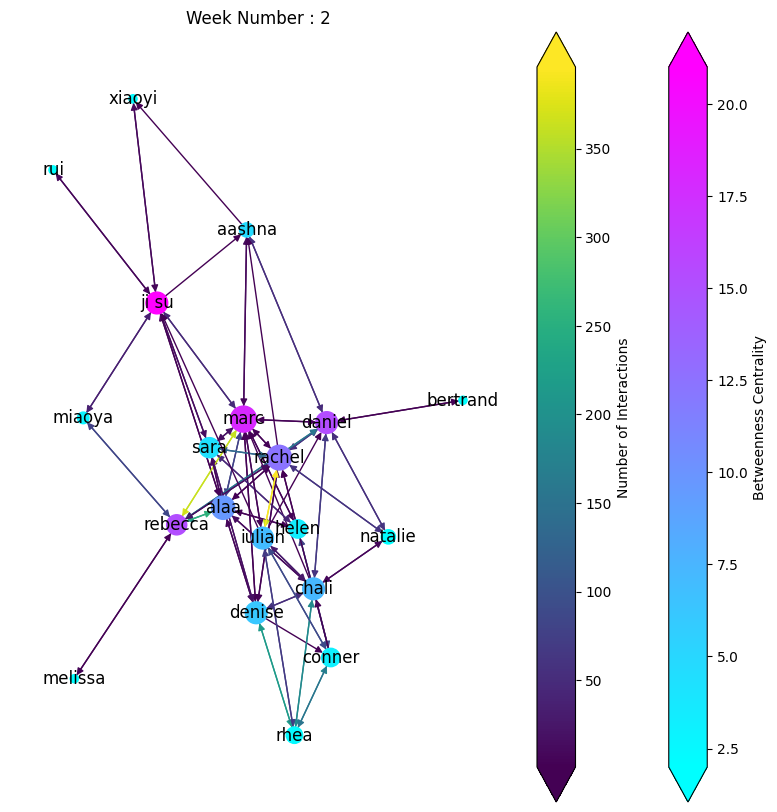

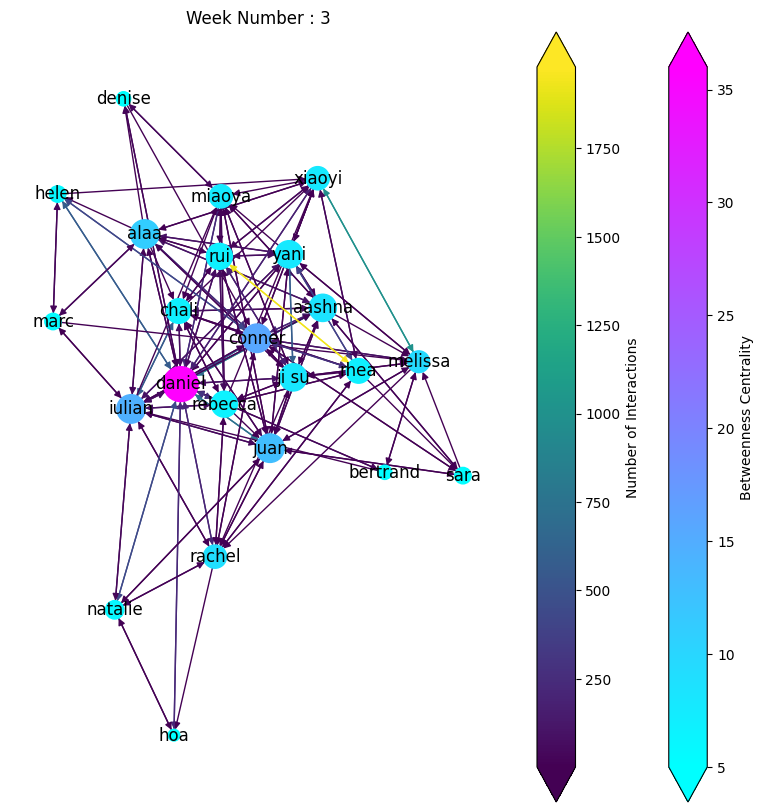

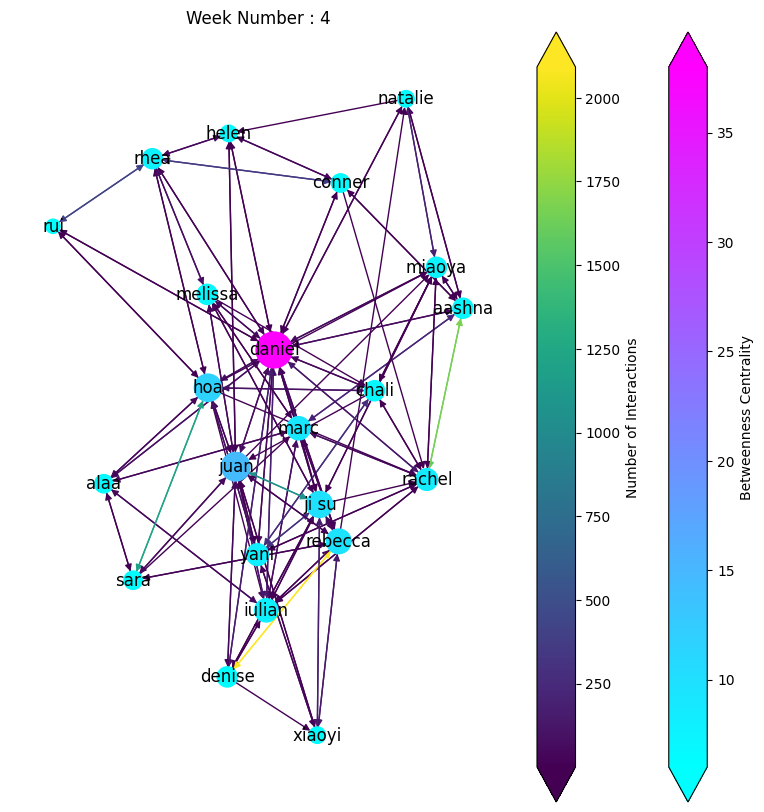

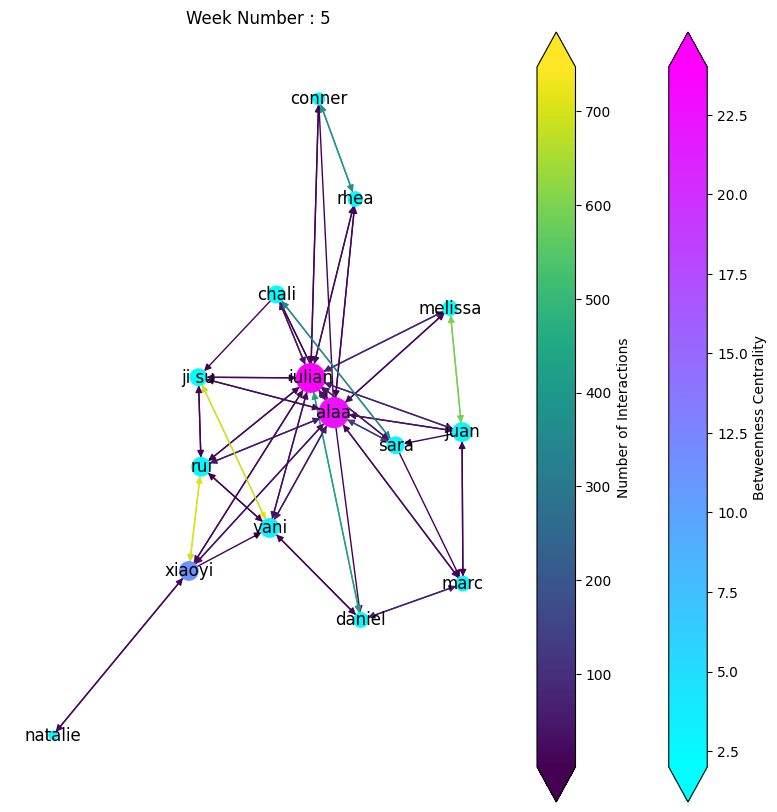

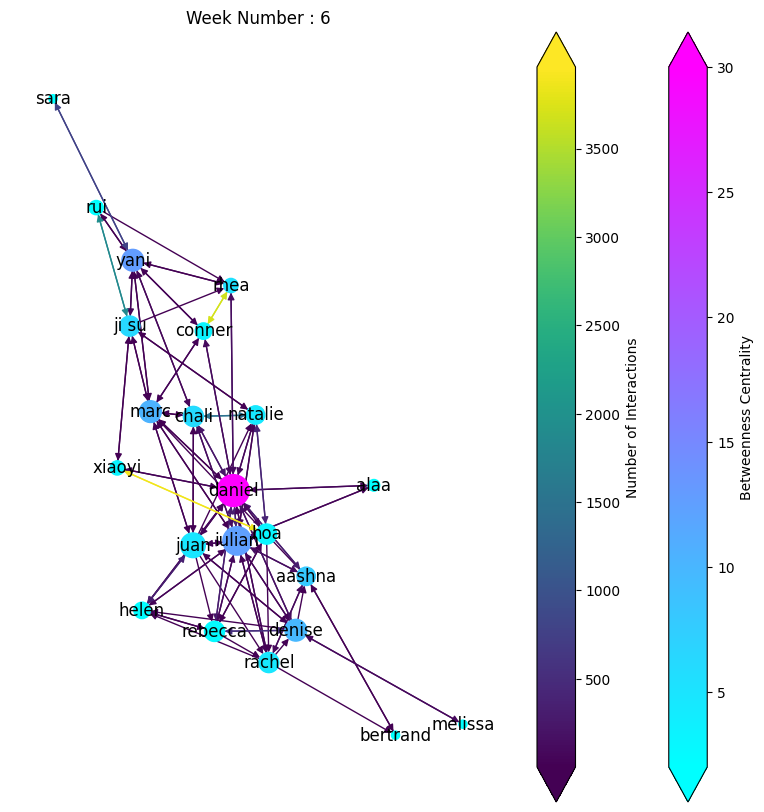

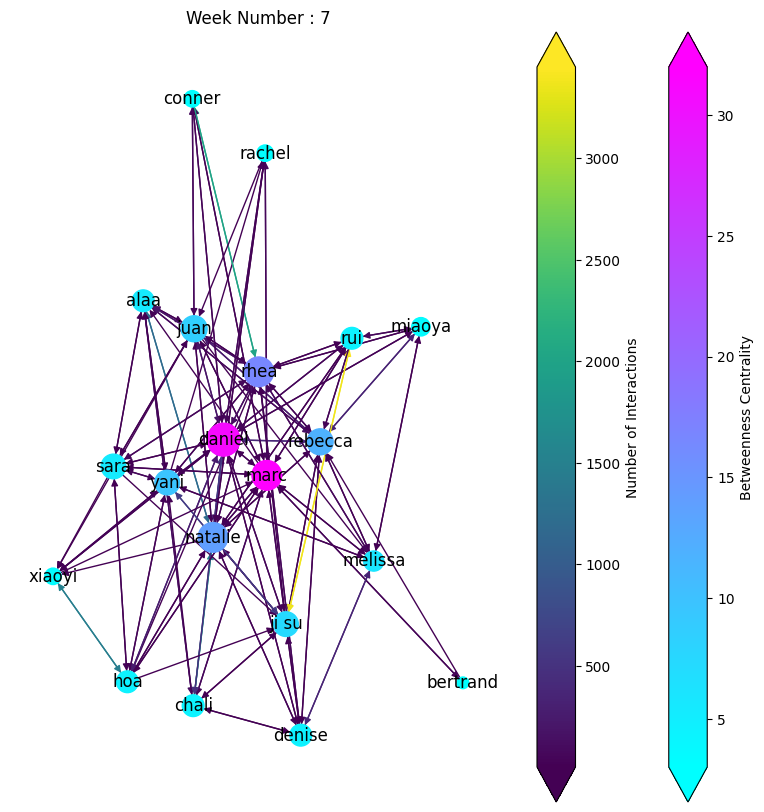

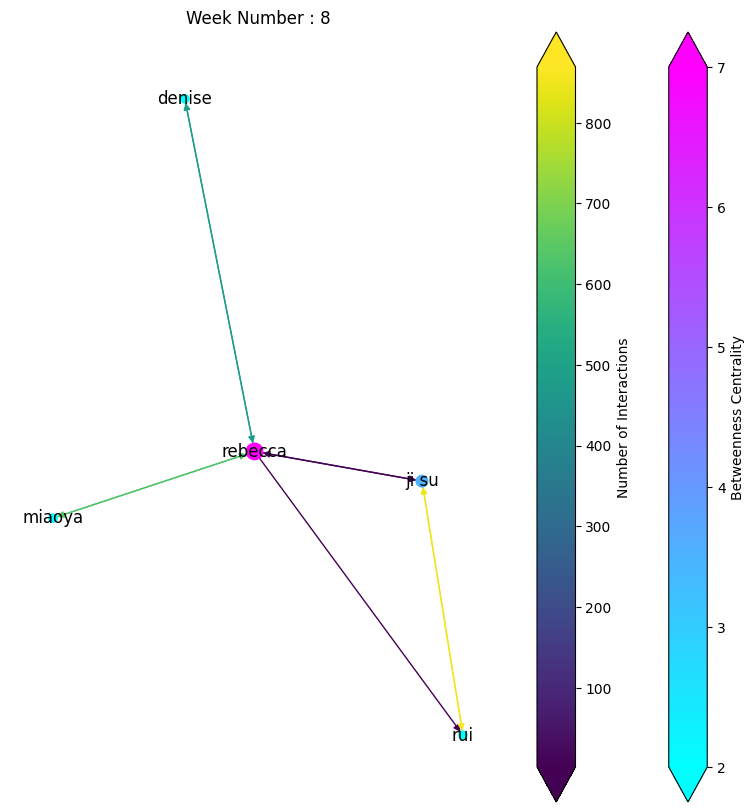

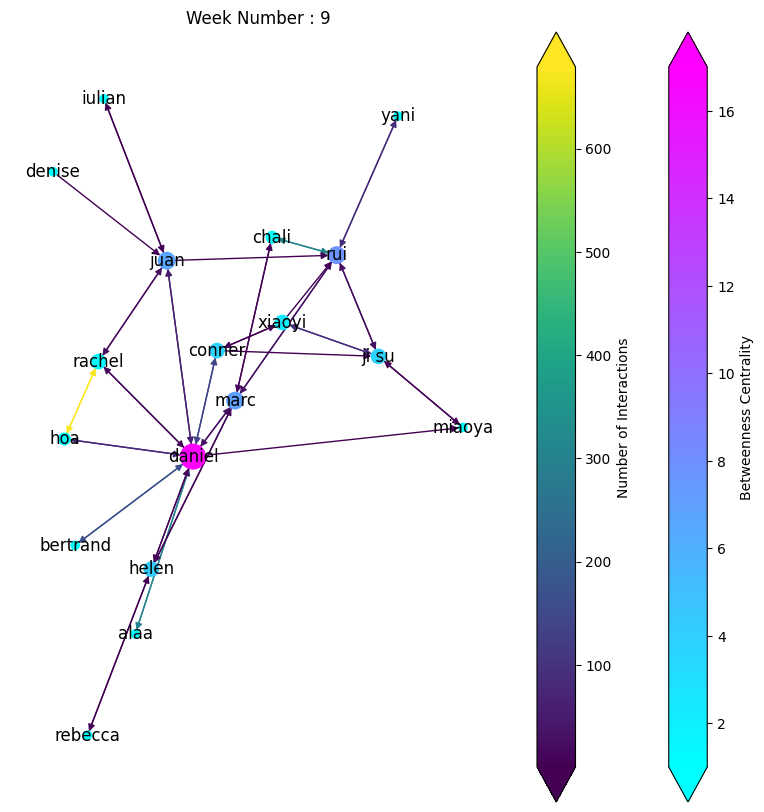

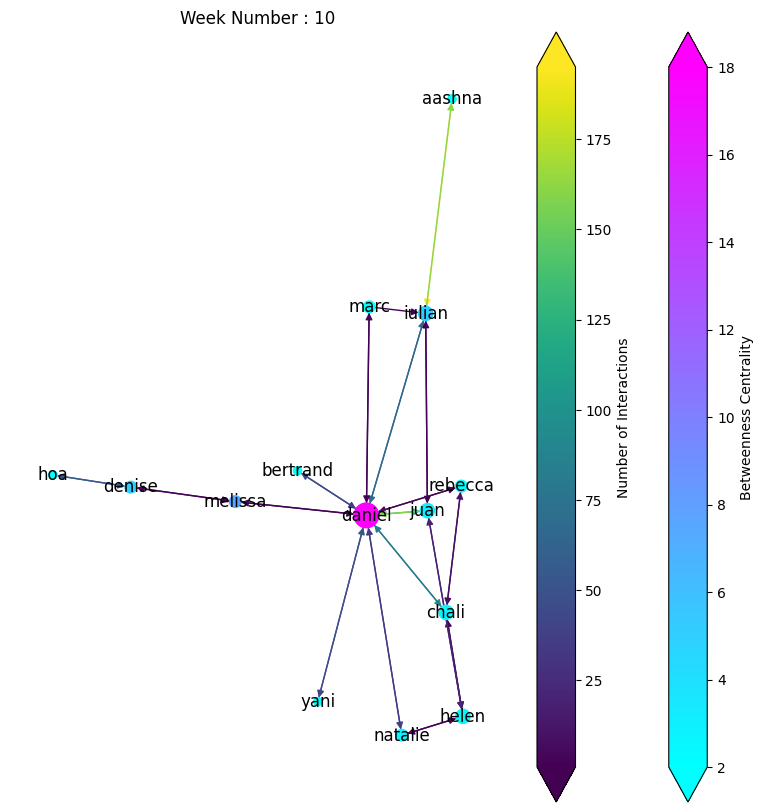

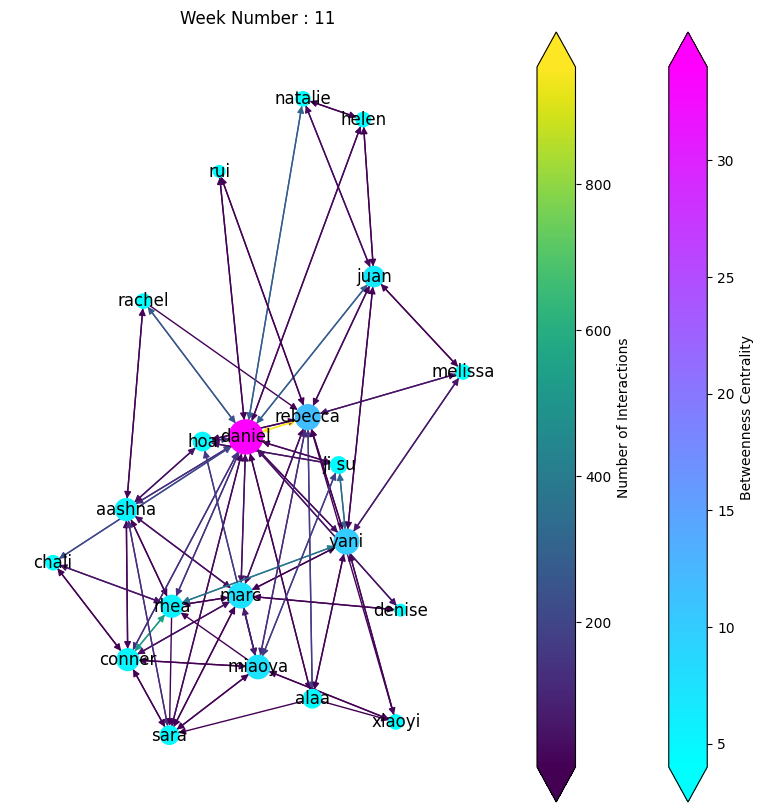

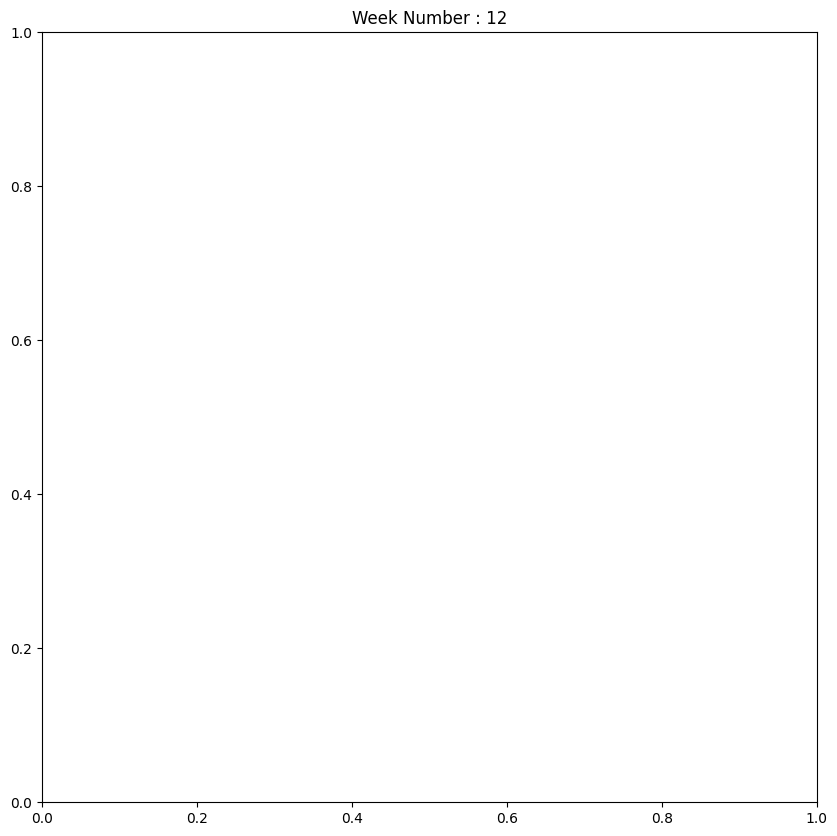

In [90]:
n = 0
for week in filtered_weeks:
    n=n+1
    if(week.empty):
        continue
    if(week.shape[0] < 3):
        continue
    Graphtype = nx.DiGraph()
    G = nx.from_pandas_edgelist(week, create_using=Graphtype, source='person_identity', target='is_oriented_toward', edge_attr='is_with_count')
    to_remove = [(a,b) for a, b, attrs in G.edges(data=True) if attrs['is_with_count'] >= 1]
    #G.remove_edges_from(to_remove)
    G2 = add_time_spent_to_group(G, week)
    tim_spent = []
    for all in nx.get_node_attributes(G2, 'time_spent'):
        tim_spent.append(nx.get_node_attributes(G2, 'time_spent')[all])
    tim_sp = nx.get_node_attributes(G2, 'time_spent')
    if(nx.number_of_nodes(G2) < 2):
        continue
    print(nx.number_of_nodes(G2))
    plt.figure(figsize=(10,10))
    plt.title('Week Number : '+str(n))
    dataplot(G2)


In [ ]:
base_path = ''
agg_path = os.path.join(base_path, '2020-Makerspace-tracking','Data', '2022-Spr-T519', 'aggregated')
scores_path = os.path.join(agg_path, 'outcome_participants_scores.csv')
scores_df = pd.read_csv(scores_path)
scores_df.rename(columns={'student_id':'person_identity'}, inplace=True)
scores_df.head()

,Unnamed: 0,person_identity,email,mid_gain_se,final_raw_se,total_gain_se,mid_gain_com,mid_gain_se_norm,mid_gain_com_norm,final_raw_com,total_gain_com,score,enjoyment,stress_level,time_on_assignment
0,0,aashna,aashnasaraf@gse.harvard.edu,-5,8,-4,0.3750,0.250000,0.409091,1.750,0.500,0.164773,2.769231,2.153846,5.923077
1,1,conner,ceastman@gse.harvard.edu,-7,14,-1,2.0000,0.083333,1.000000,2.000,2.000,0.479167,2.384615,2.615385,5.769231
2,2,chali,chalisakaewla@gse.harvard.edu,-1,10,6,0.5000,0.583333,0.454545,1.500,1.500,0.509470,2.000000,1.846154,4.384615
3,3,denise,denisefabella@gse.harvard.edu,-4,7,-2,-0.0625,0.333333,0.250000,1.125,0.375,0.437500,3.153846,2.230769,4.384615
4,4,helen,helen_turner@gse.harvard.edu,3,16,6,-0.7500,0.916667,0.000000,1.500,-0.500,0.645833,3.071429,1.928571,4.285714


In [ ]:
time_spent_dat = dat.groupby(['person_identity']).size().reset_index(name='time_spent')
print(time_spent_dat)

time_with_dat = grouped_data.groupby(['person_identity']).size().reset_index(name='time_with')
print(time_with_dat)

node_t_s = time_spent_dat.set_index('time_spent').to_dict()['person_identity']
#is_with_ln2 = grouped_data.set_index('is_with_count_ln2').to_dict()['person_identity', 'is_oriented_toward']

nx.set_node_attributes(G, node_t_s, 'time_spent')
master_df = grouped_data.merge(time_spent_dat, on='person_identity', how='left')
master_df.head()

   person_identity  time_spent
0           aashna      201689
1             alaa      148132
2         bertrand       16997
3            chali      235414
4           conner      227262
5           daniel      646704
6           denise      159820
7            helen      220884
8              hoa      239787
9           iulian      173539
10           ji su      190721
11            juan      351467
12            marc      440781
13         melissa      136498
14          miaoya      116847
15         natalie      165457
16          rachel      171634
17         rebecca      167397
18            rhea      244374
19             rui      171430
20            sara       73296
21    unidentified     1801838
22          xiaoyi      142707
23            yani      306326
   person_identity  time_with
0           aashna         21
1             alaa         20
2         bertrand          8
3            chali         20
4           conner         21
5           daniel         22
6           den

,person_identity,is_oriented_toward,is_with_count,is_with_count_ln2,time_spent
0,aashna,alaa,876,9.774787,201689
1,aashna,bertrand,2,1.000000,201689
2,aashna,chali,174,7.442943,201689
3,aashna,conner,244,7.930737,201689
4,aashna,daniel,1832,10.839204,201689


In [ ]:
master_df = master_df.merge(scores_df, on='person_identity')
master_df.rename(columns={'Unnamed: 0':'person_code'}, inplace=True)
master_df

,person_identity,is_oriented_toward,is_with_count,is_with_count_ln2,time_spent,person_code,email,mid_gain_se,final_raw_se,total_gain_se,mid_gain_com,mid_gain_se_norm,mid_gain_com_norm,final_raw_com,total_gain_com,score,enjoyment,stress_level,time_on_assignment
0,aashna,alaa,876,9.774787,201689,0,aashnasaraf@gse.harvard.edu,-5,8,-4,0.375,0.25,0.409091,1.75,0.500,0.164773,2.769231,2.153846,5.923077
1,aashna,bertrand,2,1.000000,201689,0,aashnasaraf@gse.harvard.edu,-5,8,-4,0.375,0.25,0.409091,1.75,0.500,0.164773,2.769231,2.153846,5.923077
2,aashna,chali,174,7.442943,201689,0,aashnasaraf@gse.harvard.edu,-5,8,-4,0.375,0.25,0.409091,1.75,0.500,0.164773,2.769231,2.153846,5.923077
3,aashna,conner,244,7.930737,201689,0,aashnasaraf@gse.harvard.edu,-5,8,-4,0.375,0.25,0.409091,1.75,0.500,0.164773,2.769231,2.153846,5.923077
4,aashna,daniel,1832,10.839204,201689,0,aashnasaraf@gse.harvard.edu,-5,8,-4,0.375,0.25,0.409091,1.75,0.500,0.164773,2.769231,2.153846,5.923077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,yani,rebecca,5,2.321928,306326,17,yanisu@gse.harvard.edu,4,15,9,0.375,1.00,0.409091,2.00,0.375,0.477273,2.769231,1.692308,4.384615
346,yani,rhea,806,9.654636,306326,17,yanisu@gse.harvard.edu,4,15,9,0.375,1.00,0.409091,2.00,0.375,0.477273,2.769231,1.692308,4.384615
347,yani,rui,158,7.303781,306326,17,yanisu@gse.harvard.edu,4,15,9,0.375,1.00,0.409091,2.00,0.375,0.477273,2.769231,1.692308,4.384615
348,yani,sara,860,9.748193,306326,17,yanisu@gse.harvard.edu,4,15,9,0.375,1.00,0.409091,2.00,0.375,0.477273,2.769231,1.692308,4.384615


In [ ]:
master_df.columns

Index(['person_identity', 'is_oriented_toward', 'is_with_count',
       'is_with_count_ln2', 'time_spent', 'person_code', 'email',
       'mid_gain_se', 'final_raw_se', 'total_gain_se', 'mid_gain_com',
       'mid_gain_se_norm', 'mid_gain_com_norm', 'final_raw_com',
       'total_gain_com', 'score', 'enjoyment', 'stress_level',
       'time_on_assignment'],
      dtype='object')

In [ ]:
# load the script
script = os.path.join(base_path, '2020-Makerspace-tracking', 'Analysis', 'helpers', '[ Archives ]', 'augment_df.py')
%run "$script"

# load the script for generating correlation heatmaps
script_heatmap = os.path.join(base_path, '2020-Makerspace-tracking', 'Analysis', 'helpers', 'heatmap.py')
%run "$script_heatmap"

In [ ]:
# define our predictors (rows) and outcomes (columns)
predictors = ['time_spent']
outcomes = ['mid_gain_se', 'mid_gain_com', 'enjoyment', 'stress_level','mid_gain_se_norm', 'mid_gain_com_norm', 'enjoyment','stress_level', 'score']

#compute_correlation(master_df, predictors, outcomes)

C:\Users\louis\AppData\Local\Temp\ipykernel_3228\3340210797.py:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min(d.values()),vmax=max(d.values())),cmap=cmap), cax=None, extend='both', orientation='vertical', label = 'Degree of Nodes')
C:\Users\louis\AppData\Local\Temp\ipykernel_3228\3340210797.py:12: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar2 = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min([e[2]['is_with_count'] for e 

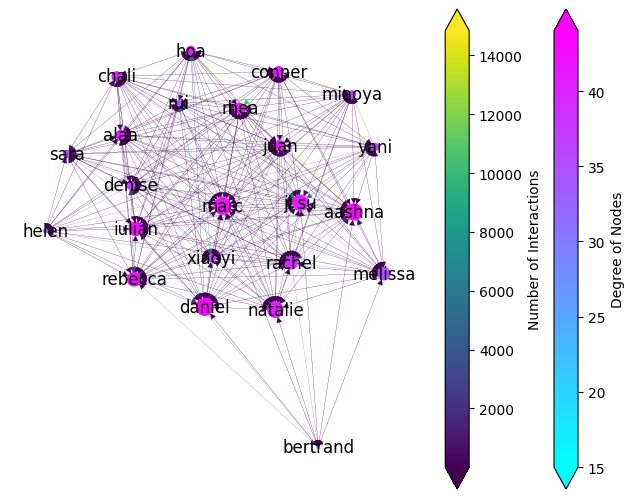

In [ ]:

#Data Analysis
Graphtype = nx.DiGraph()
G = nx.from_pandas_edgelist(grouped_data, create_using=Graphtype, source='person_identity', target='is_oriented_toward', edge_attr='is_with_count')
btc = nx.betweenness_centrality(G)
ln2_list = list(grouped_data['is_with_count_ln2'])
cmap = plt.get_cmap('cool')
cmap2 = plt.get_cmap('viridis')
d = dict(nx.degree(G))
nx.spring_layout(G)
nx.draw(G, node_size=[v * 10000 for v in btc.values()], cmap = cmap, vmin = min(d.values()), vmax = max(d.values()), node_color=[v for v in d.values()], edge_cmap = cmap2, edge_color = [e[2]['is_with_count'] for e in G.edges(data=True)], with_labels=True, edge_vmin = min([e[2]['is_with_count'] for e in G.edges(data=True)]), edge_vmax = max([e[2]['is_with_count'] for e in G.edges(data=True)]), width = 0.1)
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min(d.values()),vmax=max(d.values())),cmap=cmap), cax=None, extend='both', orientation='vertical', label = 'Degree of Nodes')
cbar2 = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min([e[2]['is_with_count'] for e in G.edges(data=True)]),vmax=max([e[2]['is_with_count'] for e in G.edges(data=True)])),cmap=cmap2), cax=None, extend='both', orientation='vertical', label = 'Number of Interactions')

In [ ]:
#print(nx.prominent_group(G,2))
#print(nx.prominent_group(G,3))
#print(nx.prominent_group(G,4))
#print(nx.prominent_group(G,5))

In [ ]:
#nx.second_order_centrality(G)
#nx.clustering(G, weight='counts')


In [ ]:
nx.voterank(G,8)
nx.barycenter(G, weight='is_with_count')
community_list = nx.community.louvain_communities(G, weight='is_with_count')
print(community_list)

[{'aashna', 'sara', 'hoa', 'rachel'}, {'marc', 'juan', 'daniel', 'helen', 'iulian', 'bertrand'}, {'ji su', 'yani', 'rui', 'xiaoyi'}, {'rebecca', 'denise', 'melissa', 'miaoya'}, {'chali', 'natalie', 'alaa'}, {'rhea', 'conner'}]


In [ ]:
node_t_s = time_spent_dat.set_index('person_identity').to_dict()['time_spent']
#is_with_ln2 = grouped_data.set_index('is_with_count_ln2').to_dict()['person_identity', 'is_oriented_toward']

nx.set_node_attributes(G, node_t_s, 'time_spent')
print(node_t_s)
tim_sp = nx.get_node_attributes(G, 'time_spent')
for all in tim_sp:
    print(nx.get_node_attributes(G, 'time_spent')[all])

{'aashna': 201689, 'alaa': 148132, 'bertrand': 16997, 'chali': 235414, 'conner': 227262, 'daniel': 646704, 'denise': 159820, 'helen': 220884, 'hoa': 239787, 'iulian': 173539, 'ji su': 190721, 'juan': 351467, 'marc': 440781, 'melissa': 136498, 'miaoya': 116847, 'natalie': 165457, 'rachel': 171634, 'rebecca': 167397, 'rhea': 244374, 'rui': 171430, 'sara': 73296, 'unidentified': 1801838, 'xiaoyi': 142707, 'yani': 306326}
201689
148132
16997
235414
227262
646704
220884
239787
173539
190721
351467
440781
136498
116847
165457
171634
167397
244374
171430
73296
142707
306326
159820


C:\Users\louis\AppData\Local\Temp\ipykernel_3228\2793360808.py:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min(d.values()),vmax=max(d.values())),cmap=cmap), cax=None, extend='both', orientation='vertical', label = 'Degree of Nodes')
C:\Users\louis\AppData\Local\Temp\ipykernel_3228\2793360808.py:12: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar2 = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min([e[2]['is_with_count'] for e 

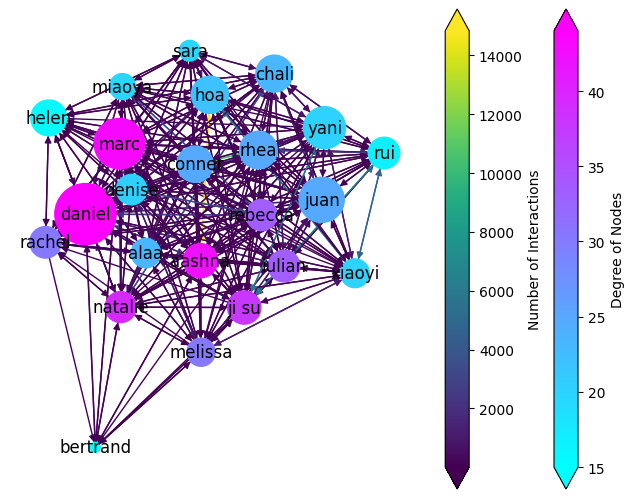

In [ ]:
def dataplot(Group):
    btc = nx.betweenness_centrality(Group)
    tim_spent = []
    for all in nx.get_node_attributes(Group, 'time_spent'):
        tim_spent.append(nx.get_node_attributes(Group, 'time_spent')[all])
    cmap = plt.get_cmap('cool')
    cmap2 = plt.get_cmap('viridis')
    d = dict(nx.degree(Group))
    nx.spring_layout(Group)
    nx.draw(Group, node_size=[v * .003 for v in tim_spent ], cmap = cmap, vmin = min(btc.values()), vmax = max(btc.values()), node_color=[b for b in btc.values()], edge_cmap = cmap2, edge_color = [e[2]['is_with_count'] for e in Group.edges(data=True)], with_labels=True, edge_vmin = min([e[2]['is_with_count'] for e in Group.edges(data=True)]), edge_vmax = max([e[2]['is_with_count'] for e in Group.edges(data=True)]))
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min(d.values()),vmax=max(d.values())),cmap=cmap), cax=None, extend='both', orientation='vertical', label = 'Degree of Nodes')
    cbar2 = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min([e[2]['is_with_count'] for e in Group.edges(data=True)]),vmax=max([e[2]['is_with_count'] for e in Group.edges(data=True)])),cmap=cmap2), cax=None, extend='both', orientation='vertical', label = 'Number of Interactions')



dataplot(G)

#G_group1 = G.subgraph(community_list[0])
#G_group2 = G.subgraph(community_list[1])
#G_group3 = G.subgraph(community_list[2])
#G_group4 = G.subgraph(community_list[3])
#G_group5 = G.subgraph(community_list[4])


In [ ]:
dataplot(G_group1)

NameError: name 'G_group1' is not defined

C:\Users\louis\AppData\Local\Temp\ipykernel_16280\3004562199.py:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min(d.values()),vmax=max(d.values())),cmap=cmap), cax=None, extend='both', orientation='vertical', label = 'Degree of Nodes')
C:\Users\louis\AppData\Local\Temp\ipykernel_16280\3004562199.py:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar2 = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min([e[2]['is_with_count'] for 

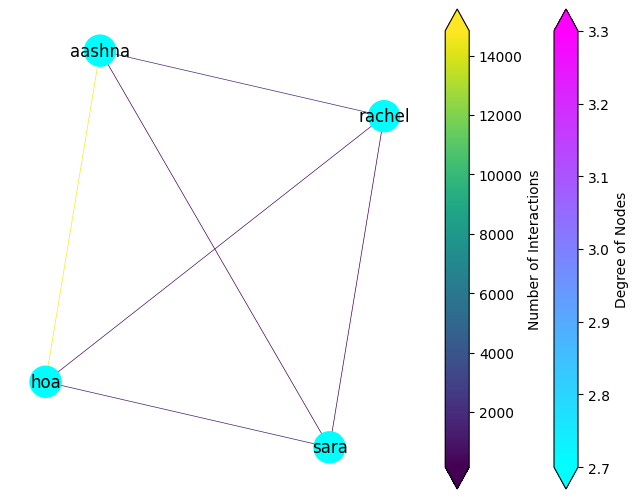

In [ ]:
dataplot(G_group2)

C:\Users\louis\AppData\Local\Temp\ipykernel_16280\3004562199.py:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min(d.values()),vmax=max(d.values())),cmap=cmap), cax=None, extend='both', orientation='vertical', label = 'Degree of Nodes')
C:\Users\louis\AppData\Local\Temp\ipykernel_16280\3004562199.py:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar2 = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min([e[2]['is_with_count'] for 

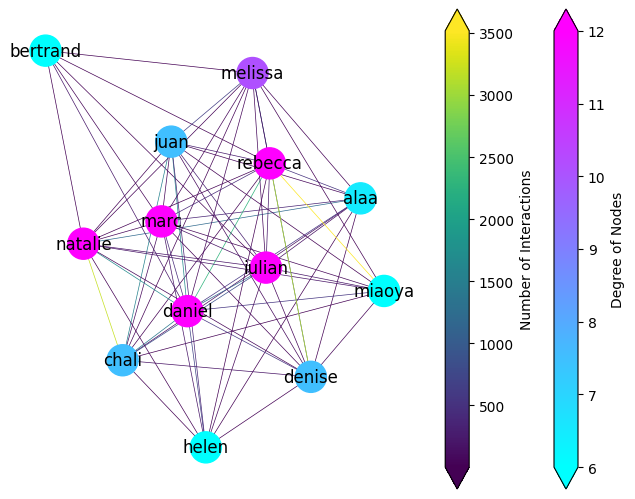

In [ ]:
dataplot(G_group3)

C:\Users\louis\AppData\Local\Temp\ipykernel_16280\3004562199.py:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min(d.values()),vmax=max(d.values())),cmap=cmap), cax=None, extend='both', orientation='vertical', label = 'Degree of Nodes')
C:\Users\louis\AppData\Local\Temp\ipykernel_16280\3004562199.py:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar2 = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min([e[2]['is_with_count'] for 

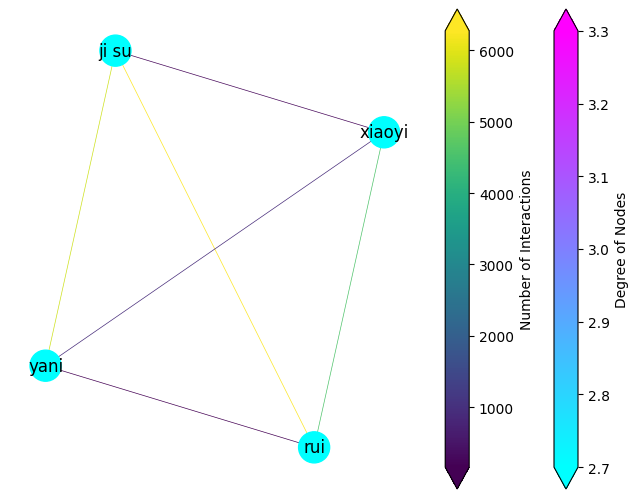

In [ ]:
dataplot(G_group4)

C:\Users\louis\AppData\Local\Temp\ipykernel_36672\57304393.py:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min(d.values()),vmax=max(d.values())),cmap=cmap), cax=None, extend='both', orientation='vertical', label = 'Degree of Nodes')
C:\Users\louis\AppData\Local\Temp\ipykernel_36672\57304393.py:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar2 = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min([e[2]['is_with_count'] for e in

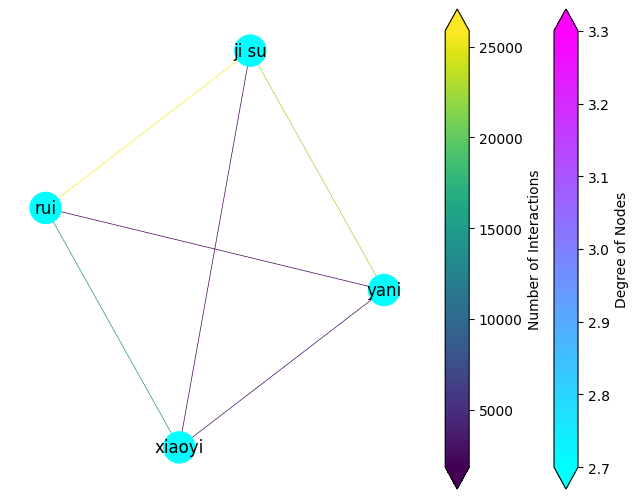

In [ ]:
dataplot(G_group5)